In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# utils imports
import utils.data as data
import utils.model as model
import utils.training as training

In [2]:
'''## Test model:

generate a model with: 
2 layers, 
model dimension of 24, 
4 attention heads, 
feed forward network depth of 64, 
maximum sequence context of 400,
using the biotac embedding mechanism (single hidden layer mlp for learned embedding)

''' 
test_model = model.TransformerClassifier(2, 24, 4, 64, 400, embedding=model.biotac_embedding)

## Provide arbitrary input sequence and check output spec
temp_input = tf.random.uniform((1,43,19), dtype=tf.float32, minval=0, maxval=1)
fn_out = test_model(temp_input, training=False,enc_padding_mask=None,)
print(fn_out)

tf.Tensor(
[[0.05089927 0.02945073 0.04959756 0.00906704 0.03000103 0.0993549
  0.0462094  0.06253598 0.02672099 0.09202754 0.03378806 0.02571888
  0.03680121 0.02952146 0.05801266 0.13792706 0.01584475 0.03066453
  0.05858196 0.07727493]], shape=(1, 20), dtype=float32)


In [3]:
## Summary of the transformer classifier:
test_model.summary()

Model: "transformer_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  12392     
_________________________________________________________________
global_average_pooling1d (Gl multiple                  0         
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_14 (Dense)             multiple                  800       
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_15 (Dense)             multiple                  660       
Total params: 13,852
Trainable params: 13,852
Non-trainable params: 0
________________________________________

In [6]:
def train_and_eval_k_fold(k):
    ''' Helper function which bundles the training and validation loops into a single function call
    Args:
        k - dataset fold - int [0,3]
    Returns:
        val_accuracy - overall accuracy on the validation dataset for final classification
        sequential_val_accuracy - sequential accuracy on the validation dataset for varying length inputs
    '''
    
    # Load, process and batch the dataset fold k
    datasets = data.load_data("path/to/dataset/BioTac_slide_20_50/compiled_data/",
                                        k = k,
                                        batch_size=40)
    train_ds = datasets['bio']['train']
    val_ds = datasets['bio']['val']
    
    # Generate the specific optimizer
    learning_rate = training.CustomSchedule(20, warmup_steps=400)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                         epsilon=1e-9)
    
    # Generate the specific model
    transformer = model.TransformerClassifier(2, 24, 4, 64, 400, embedding=model.biotac_embedding)
    
    # Initialise the model checkpoint system
    checkpoint_path = f"./biotac_testing/checkpoints_fold_{k}/train"
    ckpt = tf.train.Checkpoint(transformer=transformer,
                               optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    # if a checkpoint exists, restore the latest checkpoint.
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print('Latest checkpoint restored!!')
        
    
    # Generate input signature of UNKNOWN sequence length
    train_step_signature = [
        tf.TensorSpec(shape=(None, None, 19), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    ]
    
    # Using sparse categorical cross entropy loss
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Define individual training step
    @tf.function(input_signature=train_step_signature)
    def train_step(inp_seq, material):

        with tf.GradientTape() as tape:
            predictions = transformer(inp_seq, True, None)
            loss = loss_object(material, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        return predictions, loss
    
    # define number of epochs
    num_epochs = 300
    
    # Run the training sequence for num_epochs
    for epoch in range(num_epochs):
        start = time.time()

        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for (batch, (inp, tar)) in enumerate(train_ds):
            # train with random sequence length
            seq_length = tf.random.uniform(shape=[],minval=1, maxval=401, dtype=tf.int64) 
            predictions, loss = train_step(inp[:,0:seq_length,...], tar)
            epoch_loss_avg.update_state(loss)
            epoch_accuracy.update_state(tar, predictions)

        if (epoch+1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

            print(f'Epoch {epoch + 1} Loss {epoch_loss_avg.result():.4f} Accuracy {epoch_accuracy.result():.4f}')

            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
    
    ## begin validation on final classification as well as sequential classification
    print("."*80)
    
    print(f"Starting eval on fold {k} ...")
    
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for (batch, (inp, tar)) in enumerate(val_ds):
            predictions = transformer(inp, False, None)
            val_accuracy.update_state(tar, predictions)
    print(f"Test dataset accuracy: {val_accuracy.result():.4f}")
    
    print(f"Starting sequence eval on fold {k} ...")
    
    sequential_val_accuracy = []
    for i in range(1,400):
        indiv_val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        for (batch, (inp, tar)) in enumerate(val_ds):
            predictions = transformer(inp[:,0:i,:], False, None)
            indiv_val_accuracy.update_state(tar, predictions)
        sequential_val_accuracy.append(indiv_val_accuracy.result())
    
    print("."*80)
        
    return val_accuracy, sequential_val_accuracy

In [16]:
## perform the k training and eval iteration and compute the mean results for both the overall and sequence results
overall_val_accuracy = []
overall_sequential_val_accuracy = []

for fold in range(4):
    val_accuracy, sequential_val_accuracy = train_and_eval_k_fold(fold)
    overall_val_accuracy.append(val_accuracy)
    overall_sequential_val_accuracy.append(sequential_val_accuracy)

Loading Datasets - k-fold =  0
................................................................................
BioTac training dataset shape:  (600, 400, 19)
Icub training dataset shape:  (600, 75, 6, 10, 1)
BioTac validation dataset shape:  (200, 400, 19)
Icub validation dataset shape:  (200, 75, 6, 10, 1)
................................................................................
Latest checkpoint restored!!
Saving checkpoint for epoch 5 at ./biotac_testing/checkpoints_fold_0/train/ckpt-241
Epoch 5 Loss 0.0497 Accuracy 0.9867
Time taken for 1 epoch: 0.21 secs

Saving checkpoint for epoch 10 at ./biotac_testing/checkpoints_fold_0/train/ckpt-242
Epoch 10 Loss 0.0343 Accuracy 0.9867
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 15 at ./biotac_testing/checkpoints_fold_0/train/ckpt-243
Epoch 15 Loss 0.1201 Accuracy 0.9550
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 20 at ./biotac_testing/checkpoints_fold_0/train/ckpt-244
Epoch 20 Loss 0.0148 Accur

Saving checkpoint for epoch 255 at ./biotac_testing/checkpoints_fold_0/train/ckpt-291
Epoch 255 Loss 0.0282 Accuracy 0.9867
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 260 at ./biotac_testing/checkpoints_fold_0/train/ckpt-292
Epoch 260 Loss 0.1196 Accuracy 0.9650
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 265 at ./biotac_testing/checkpoints_fold_0/train/ckpt-293
Epoch 265 Loss 0.1270 Accuracy 0.9617
Time taken for 1 epoch: 0.20 secs

Saving checkpoint for epoch 270 at ./biotac_testing/checkpoints_fold_0/train/ckpt-294
Epoch 270 Loss 0.0460 Accuracy 0.9850
Time taken for 1 epoch: 0.21 secs

Saving checkpoint for epoch 275 at ./biotac_testing/checkpoints_fold_0/train/ckpt-295
Epoch 275 Loss 0.0041 Accuracy 0.9983
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 280 at ./biotac_testing/checkpoints_fold_0/train/ckpt-296
Epoch 280 Loss 0.1437 Accuracy 0.9483
Time taken for 1 epoch: 0.20 secs

Saving checkpoint for epoch 285 at ./biotac_te

Saving checkpoint for epoch 195 at ./biotac_testing/checkpoints_fold_1/train/ckpt-159
Epoch 195 Loss 0.0624 Accuracy 0.9817
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 200 at ./biotac_testing/checkpoints_fold_1/train/ckpt-160
Epoch 200 Loss 0.0339 Accuracy 0.9867
Time taken for 1 epoch: 0.20 secs

Saving checkpoint for epoch 205 at ./biotac_testing/checkpoints_fold_1/train/ckpt-161
Epoch 205 Loss 0.0914 Accuracy 0.9700
Time taken for 1 epoch: 0.21 secs

Saving checkpoint for epoch 210 at ./biotac_testing/checkpoints_fold_1/train/ckpt-162
Epoch 210 Loss 0.1207 Accuracy 0.9583
Time taken for 1 epoch: 0.23 secs

Saving checkpoint for epoch 215 at ./biotac_testing/checkpoints_fold_1/train/ckpt-163
Epoch 215 Loss 0.0556 Accuracy 0.9850
Time taken for 1 epoch: 0.22 secs

Saving checkpoint for epoch 220 at ./biotac_testing/checkpoints_fold_1/train/ckpt-164
Epoch 220 Loss 0.1364 Accuracy 0.9533
Time taken for 1 epoch: 0.21 secs

Saving checkpoint for epoch 225 at ./biotac_te

Saving checkpoint for epoch 135 at ./biotac_testing/checkpoints_fold_2/train/ckpt-147
Epoch 135 Loss 0.0443 Accuracy 0.9900
Time taken for 1 epoch: 0.21 secs

Saving checkpoint for epoch 140 at ./biotac_testing/checkpoints_fold_2/train/ckpt-148
Epoch 140 Loss 0.0840 Accuracy 0.9733
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 145 at ./biotac_testing/checkpoints_fold_2/train/ckpt-149
Epoch 145 Loss 0.0653 Accuracy 0.9783
Time taken for 1 epoch: 0.18 secs

Saving checkpoint for epoch 150 at ./biotac_testing/checkpoints_fold_2/train/ckpt-150
Epoch 150 Loss 0.0348 Accuracy 0.9883
Time taken for 1 epoch: 0.21 secs

Saving checkpoint for epoch 155 at ./biotac_testing/checkpoints_fold_2/train/ckpt-151
Epoch 155 Loss 0.2264 Accuracy 0.9300
Time taken for 1 epoch: 0.20 secs

Saving checkpoint for epoch 160 at ./biotac_testing/checkpoints_fold_2/train/ckpt-152
Epoch 160 Loss 0.0412 Accuracy 0.9867
Time taken for 1 epoch: 0.18 secs

Saving checkpoint for epoch 165 at ./biotac_te

Saving checkpoint for epoch 75 at ./biotac_testing/checkpoints_fold_3/train/ckpt-135
Epoch 75 Loss 0.2678 Accuracy 0.9067
Time taken for 1 epoch: 0.18 secs

Saving checkpoint for epoch 80 at ./biotac_testing/checkpoints_fold_3/train/ckpt-136
Epoch 80 Loss 0.1449 Accuracy 0.9383
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 85 at ./biotac_testing/checkpoints_fold_3/train/ckpt-137
Epoch 85 Loss 0.1553 Accuracy 0.9450
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 90 at ./biotac_testing/checkpoints_fold_3/train/ckpt-138
Epoch 90 Loss 0.1722 Accuracy 0.9400
Time taken for 1 epoch: 0.21 secs

Saving checkpoint for epoch 95 at ./biotac_testing/checkpoints_fold_3/train/ckpt-139
Epoch 95 Loss 0.1078 Accuracy 0.9600
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 100 at ./biotac_testing/checkpoints_fold_3/train/ckpt-140
Epoch 100 Loss 0.1723 Accuracy 0.9400
Time taken for 1 epoch: 0.18 secs

Saving checkpoint for epoch 105 at ./biotac_testing/chec

tf.Tensor(0.96000004, shape=(), dtype=float32)


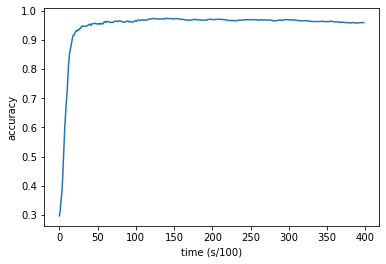

In [17]:
overall_accuracy = 0
for i in range(4):
    overall_accuracy += overall_val_accuracy[i].result()
overall_accuracy = overall_accuracy/4
print(overall_accuracy)

overall_sequence = tf.reduce_mean(tf.convert_to_tensor(overall_sequential_val_accuracy), axis=-2)
plt.plot(overall_sequence)
plt.ylabel("accuracy")
plt.xlabel("time (s/100)")

plt.show()

In [18]:
print(overall_sequence)

tf.Tensor(
[0.29625    0.315      0.34625    0.37124997 0.41250002 0.47875002
 0.53749996 0.6        0.64625    0.68625    0.71999997 0.7725
 0.8175     0.8475     0.865      0.8775     0.89250004 0.90625006
 0.91625    0.91625    0.92249995 0.92875    0.9325     0.93125
 0.93375003 0.93375    0.93874997 0.93875    0.9425     0.9475
 0.9475     0.9475     0.9475     0.9475     0.94875    0.94874996
 0.94875    0.95000005 0.9525     0.95374995 0.955      0.95
 0.95375    0.95625    0.95625    0.9575     0.9575     0.9575
 0.95625    0.955      0.95624995 0.95624995 0.95625    0.95375
 0.9575     0.95750004 0.955      0.95625    0.96       0.96375
 0.96375    0.96       0.96374995 0.96375    0.96375    0.9625
 0.96125    0.96125    0.96       0.96125    0.96125    0.9625
 0.96375    0.96500003 0.965      0.965      0.96375    0.96375
 0.96625    0.96625    0.965      0.96375    0.96375    0.96250004
 0.96125    0.96125    0.9625     0.96374995 0.965      0.965
 0.965      0.9625     0.96